## Import Libraries

In [21]:
import numpy as np
import pandas as pd
from typing import Tuple
import pandas_ta as ta

# visualization
import matplotlib.pyplot as plt

# backtesting library
import vectorbt as vbt

# machine learning
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    GridSearchCV,
    cross_val_predict,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# get data from TradingView
from tvDatafeed import TvDatafeed, Interval

tv = TvDatafeed()

## Import Data

In [31]:
interval = Interval.in_daily

raw_df = tv.get_hist(
    symbol="BTCUSD", exchange="BITSTAMP", interval=interval, n_bars=100000
)
raw_df

,symbol,open,high,low,close,volume
datetime,,,,,,
2011-08-18 07:00:00,BITSTAMP:BTCUSD,10.90,10.90,10.90,10.90,0.489908
2011-08-19 07:00:00,BITSTAMP:BTCUSD,11.85,11.85,11.15,11.69,1.926578
2011-08-20 07:00:00,BITSTAMP:BTCUSD,11.70,11.70,11.70,11.70,0.085470
2011-08-21 07:00:00,BITSTAMP:BTCUSD,11.70,11.70,11.70,11.70,0.085470
2011-08-22 07:00:00,BITSTAMP:BTCUSD,11.70,11.70,11.70,11.70,0.028632
...,...,...,...,...,...,...
2023-05-11 07:00:00,BITSTAMP:BTCUSD,27624.00,27640.00,26720.00,26991.00,2127.911358
2023-05-12 07:00:00,BITSTAMP:BTCUSD,26987.00,27093.00,25800.00,26811.00,4842.989848
2023-05-13 07:00:00,BITSTAMP:BTCUSD,26816.00,27052.00,26710.00,26789.00,1269.304646


## Add technical indicators

In [32]:
strategy_name = "Demo Strategy"
strategy1 = ta.Strategy(
    name="Demo Strategy",
    description="",
    ta=[
        {"kind": "adx", "length": 14, "col_names": ("ADX_14", "DMP_14", "DMN_14")},
        {
            "kind": "bbands",
            "length": 20,
            "std": 2,
            "col_names": ("BBL", "BBM", "BBU", "BBB", "BBP"),
        },
        {"kind": "ema", "length": 50},
        {"kind": "ema", "length": 100},
        {"kind": "ema", "length": 200},
        # {
        #     "kind": "donchian", "lower_length": 12, "upper_length": 24
        #     , "col_names": ("DCL", "DCM", "DCU")
        # },
        {
            "kind": "macd",
            "fast": 12,
            "slow": 26,
            "col_names": ("MACD", "MACD_H", "MACD_S"),
        },
    ],
)

strat1 = raw_df.copy()
strat1.ta.strategy(strategy1)

# strat1.head(5)

**Feedback (2023-05-10)**
- Reason for choosing each technical indicators
- Label input feature
- Label technique Y output (optional)
  - Let's try to use Y+7 instead.
- Trial method "Expanding window time-series cross-validation".

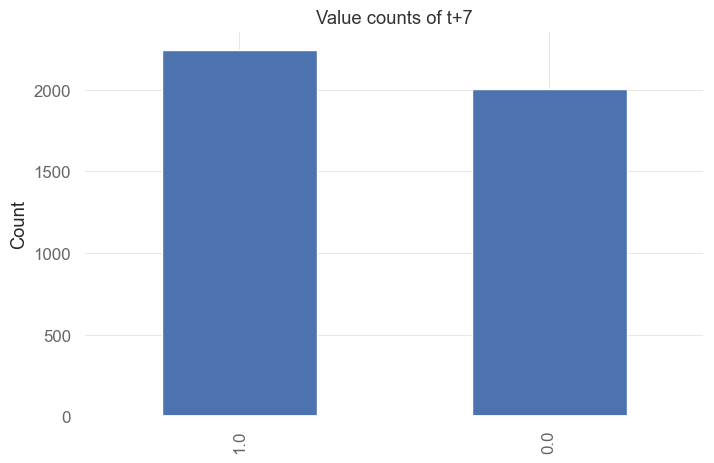

In [33]:
# label for machine learning
strat1["ret"] = strat1["close"].pct_change().shift(-7)

strat1["y"] = np.where(
    np.isnan(strat1["ret"]), strat1["ret"], np.where(strat1["ret"] > 0, 1, 0)
)

# create a bar plot of the value counts of the 'y' column
strat1["y"].value_counts().plot(kind="bar", figsize=(8, 5))

# add labels and title to the plot
plt.ylabel("Count")
plt.title("Value counts of t+7")
plt.show()

In [35]:
data = strat1.copy()

n_splits = 10

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=365)

# Perform cross-validation on the data
for k_fold, (train_index, test_index) in enumerate(tscv.split(data)):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]

    # train and evaluate your model on each fold
    # ...

    print("--------------------")
    # number of fold
    print("Fold: ", k_fold + 1)
    # Print the shapes of the training and testing sets for each fold
    print("Training data shape:", train_data.shape)
    print("Testing data shape:", test_data.shape)
    # Print the period of the training and testing sets for each fold
    print("Training date:", train_data.index[0], "-", train_data.index[-1])
    print("Testing date:", test_data.index[0], "-", test_data.index[-1])

--------------------
Fold:  1
Training data shape: (606, 22)
Testing data shape: (365, 22)
Training date: 2011-08-18 07:00:00 - 2013-05-14 07:00:00
Testing date: 2013-05-15 07:00:00 - 2014-05-14 07:00:00
--------------------
Fold:  2
Training data shape: (971, 22)
Testing data shape: (365, 22)
Training date: 2011-08-18 07:00:00 - 2014-05-14 07:00:00
Testing date: 2014-05-15 07:00:00 - 2015-05-17 07:00:00
--------------------
Fold:  3
Training data shape: (1336, 22)
Testing data shape: (365, 22)
Training date: 2011-08-18 07:00:00 - 2015-05-17 07:00:00
Testing date: 2015-05-18 07:00:00 - 2016-05-16 07:00:00
--------------------
Fold:  4
Training data shape: (1701, 22)
Testing data shape: (365, 22)
Training date: 2011-08-18 07:00:00 - 2016-05-16 07:00:00
Testing date: 2016-05-17 07:00:00 - 2017-05-16 07:00:00
--------------------
Fold:  5
Training data shape: (2066, 22)
Testing data shape: (365, 22)
Training date: 2011-08-18 07:00:00 - 2017-05-16 07:00:00
Testing date: 2017-05-17 07:00:00

## Data Cleaning

In [5]:
def num_split_data(
    data: pd.DataFrame,
    train_size: float,
    test_size: float,
    out_of_sample_size: float,
    n_splits: int,
) -> Tuple[int, int, int]:
    """
    Calculate the size of training, testing, and out-of-sample data for time series cross-validation.

    Parameters
    ----------
    data : pd.DataFrame
        A pandas DataFrame containing the time series data.
    train_size : float
        The proportion of the data to use for training.
    test_size : float
        The proportion of the data to use for testing.
    out_of_sample_size : float
        The proportion of the data to use for out-of-sample prediction.
    n_splits : int
        The number of folds to use for cross-validation.

    Returns
    -------
    Tuple[int, int, int]
        A tuple containing the sizes of the training, testing, and out-of-sample data.
    """
    # Calculate the size of out-of-sample data
    rows_out_of_sample = (len(data)) * out_of_sample_size

    # Calculate the size of train/test dat
    train_test_size = (len(data)) - rows_out_of_sample
    num_of_days = train_test_size / 24

    # Calculate the size of training and testing sets for each fold
    split_train_test_size = train_test_size // n_splits
    rows_train_size = round((split_train_test_size * train_size))
    rows_test_size = round((split_train_test_size * test_size))
    rows_out_of_sample = round(rows_out_of_sample)

    # Print the number of days, training size, and testing size for each fold
    print(f"Number of Days: {num_of_days}")
    print(f"Training Size for Each Fold: {rows_train_size}")
    print(f"Testing Size for Each Fold: {rows_test_size}")
    print(f"Out of Sample Size for Each Fold: {rows_out_of_sample}")

    return rows_train_size, rows_test_size, rows_out_of_sample

In [6]:
n_splits = 10

rows_train_size, rows_test_size, rows_out_of_sample = num_split_data(
    data=raw_df,
    train_size=0.80,
    test_size=0.20,
    out_of_sample_size=0.1,
    n_splits=n_splits,
)

Number of Days: 443.325
Training Size for Each Fold: 850
Testing Size for Each Fold: 213
Out of Sample Size for Each Fold: 1182


In [25]:
X = strat1.drop(columns=["symbol", "ret", "y"]).copy()
X = X.iloc[:, 5:]  # drop OHLC
X.dropna(inplace=True)
y = strat1["y"]
y = y[X.index]  # matching index

# The training and validation datasets are utilized to explore and determine the optimal methodology
# The testing dataset, which represents unseen data, is then used once the best result has been achieved on the training and validation datasets.
X_train_val, X_test = X.iloc[:-rows_out_of_sample], X.iloc[-rows_out_of_sample:]
y_train_val, y_test = y.iloc[:-rows_out_of_sample], y.iloc[-rows_out_of_sample:]

## Split Train/Validation Dataset

In [26]:
# training for 1 month
# week * hrs
train_size = 28 * 24

# test for 1 week
test_size = 7 * 24

In [27]:
rf = RandomForestClassifier(random_state=42)

tscv = TimeSeriesSplit(n_splits=10, max_train_size=train_size, test_size=test_size)

# Perform cross-validation on the data
for k_fold, (X_train_val_index, y_train_val_index) in enumerate(
    tscv.split(X_train_val)
):
    # X_train_val = raw_indicators.iloc[X_train_val_index]
    # y_train_val = raw_indicators.iloc[y_train_val_index]
    train_data = X_train_val.iloc[X_train_val_index]
    test_data = X_train_val.iloc[y_train_val_index]
    print("--------------------")
    # number of fold
    print("Fold: ", k_fold + 1)
    # Print the shapes of the training and testing sets for each fold
    print("Training data shape:", train_data.shape)
    print("Testing data shape:", test_data.shape)

    # Print the period of the training and testing sets for each fold
    print("Training date:", train_data.index[0], "-", train_data.index[-1])
    print("Testing date:", test_data.index[0], "-", test_data.index[-1])

--------------------
Fold:  1
Training data shape: (672, 17)
Testing data shape: (168, 17)
Training date: 2022-12-12 15:00:00 - 2023-01-09 14:00:00
Testing date: 2023-01-09 15:00:00 - 2023-01-16 14:00:00
--------------------
Fold:  2
Training data shape: (672, 17)
Testing data shape: (168, 17)
Training date: 2022-12-19 15:00:00 - 2023-01-16 14:00:00
Testing date: 2023-01-16 15:00:00 - 2023-01-23 14:00:00
--------------------
Fold:  3
Training data shape: (672, 17)
Testing data shape: (168, 17)
Training date: 2022-12-26 15:00:00 - 2023-01-23 14:00:00
Testing date: 2023-01-23 15:00:00 - 2023-01-30 14:00:00
--------------------
Fold:  4
Training data shape: (672, 17)
Testing data shape: (168, 17)
Training date: 2023-01-02 15:00:00 - 2023-01-30 14:00:00
Testing date: 2023-01-30 15:00:00 - 2023-02-06 14:00:00
--------------------
Fold:  5
Training data shape: (672, 17)
Testing data shape: (168, 17)
Training date: 2023-01-09 15:00:00 - 2023-02-06 14:00:00
Testing date: 2023-02-06 15:00:00 - 

## Normalization

In [28]:
normalizers = [
    ("scaler", None),
    ("scaler", RobustScaler()),
    ("scaler", MinMaxScaler()),
    ("scaler", StandardScaler()),
]

for i, normalizer in enumerate(normalizers):
    pipeline = Pipeline([normalizer, ("rf", RandomForestClassifier(random_state=42))])

    tscv = TimeSeriesSplit(
        n_splits=n_splits, max_train_size=train_size, test_size=test_size
    )

    score = cross_val_score(
        pipeline, X_train_val, y_train_val, scoring="roc_auc", cv=tscv
    )
    print("---------------------------")
    print(f"Normalizer: {type(normalizers[i][1]).__name__}")
    print(
        "{}: {:.4f} +- {:.4f}".format(
            type(pipeline).__name__, score.mean(), score.std()
        )
    )
    print(score)

---------------------------
Normalizer: NoneType
Pipeline: 0.5472 +- 0.0463
[0.45455205 0.56833036 0.5934798  0.54366377 0.60735544 0.47189645
 0.56257973 0.57437606 0.55102764 0.54473118]
---------------------------
Normalizer: RobustScaler
Pipeline: 0.5483 +- 0.0463
[0.45694787 0.56543375 0.5934798  0.54835727 0.61040249 0.4715389
 0.56385542 0.57437606 0.554146   0.54473118]
---------------------------
Normalizer: MinMaxScaler
Pipeline: 0.5484 +- 0.0464
[0.45694787 0.56885027 0.5934798  0.54366377 0.60735544 0.4715389
 0.56172927 0.58118264 0.554146   0.54473118]
---------------------------
Normalizer: StandardScaler
Pipeline: 0.5478 +- 0.0458
[0.45694787 0.56543375 0.5934798  0.54835727 0.60735544 0.4715389
 0.56172927 0.57437606 0.554146   0.54473118]


Select the Best Normalizer

In [29]:
# Define a parameter grid for the Random Forest model
param_grid = {
    "rf__n_estimators": [50, 100, 200],
    "rf__max_depth": [5, 10, None],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
}

pipeline = Pipeline(
    [("scaler", MinMaxScaler()), ("rf", RandomForestClassifier(random_state=42))]
)

tscv = TimeSeriesSplit(
    n_splits=n_splits, max_train_size=train_size, test_size=test_size
)

grid_search = GridSearchCV(pipeline, param_grid, scoring="roc_auc", cv=tscv)
grid_search.fit(X_train_val, y_train_val)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'rf__max_depth': 5, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Best score:  0.5599160285638713


In [30]:
# auc score
grid_search.score(X_train_val, y_train_val)

0.631409388476923

## Out of Sample

In [93]:
signal_df = X_test.copy()
signal_df["signal"] = pd.Series(data=grid_search.predict(X_test), index=X_test.index)

# convert signal as boolean
signal_df["signal"] = signal_df["signal"].apply(lambda x: True if x == 1 else False)

# more realistic
signal_df["signal"] = signal_df["signal"].shift()
signal_df.dropna(inplace=True)

# create signal backtesting
signal_vectorbt = signal_df.ta.tsignals(signal_df.signal, asbool=True, append=True)

# close price
close_price = strat1.loc[signal_df.index[0] : signal_df.index[-1]]["close"]

port = vbt.Portfolio.from_signals(
    close_price,
    entries=signal_vectorbt.TS_Entries,
    exits=signal_vectorbt.TS_Exits,
    freq="1h",
    init_cash=1000,
    size=0.1,
    # fees = 0.00075,     # 0.075% (BNB 25% off)
    # slippage = 0.001    # 0.1%
)

port.plot().show()
port.stats()

Start                               2023-03-20 16:00:00
End                                 2023-05-08 22:00:00
Period                                 49 days 05:00:00
Start Value                                      1000.0
End Value                                    787.826603
Total Return [%]                              -21.21734
Benchmark Return [%]                          -1.080217
Max Gross Exposure [%]                            100.0
Total Fees Paid                              117.815108
Max Drawdown [%]                              25.725697
Max Drawdown Duration                  46 days 08:00:00
Total Trades                                         84
Total Closed Trades                                  83
Total Open Trades                                     1
Open Trade PnL                                -25.30945
Win Rate [%]                                  36.144578
Best Trade [%]                                 3.316437
Worst Trade [%]                               -4